# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [1]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>%
    group_by(character, episode_number) %>%
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>%
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1
In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

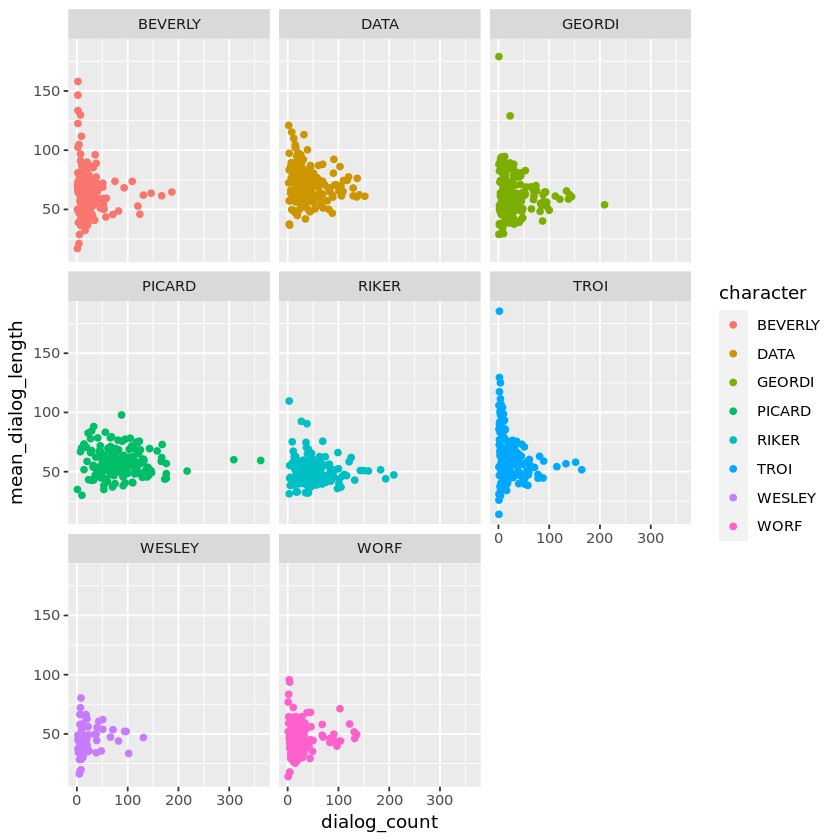

In [ ]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) +
    geom_point(aes(color=character)) +
    facet_wrap(~character)

From these plots we can tell who the important characters are by if they speak more and if they speak for longer generally. For example you can tell that Beverly and Riker are more important characters due to their large amounts of diaologe count. Troi is an important side character because he doesnt speak a lot but when he does its for a long time. And that Wesley is a non important character because he does not speak much or for very long.

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`.
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season.

In [32]:
beverly <- dialogs_fixed %>% filter(character == "BEVERLY") %>%
  filter(
    (episode_number > 101 & episode_number < 127) |
      (episode_number > 148 & episode_number < 175)
    ) %>%
      mutate(season = case_when(
        (episode_number > 101 & episode_number < 127) ~ 1,
        (episode_number > 148 & episode_number < 175) ~ 3
      )) %>%
        group_by(season, episode_number) %>%
        summarise(times_talked = n(), .groups = "drop")


beverly_season_means <- beverly %>%
  group_by(season) %>%
  summarise(mean_dialog = mean(times_talked))

beverly_season_means



season,mean_dialog
<dbl>,<dbl>
1,25.40
3,19.64


In [54]:
summary(dialogs_fixed)

 episode_number   character            dialog          dialog_length   
 Min.   :102.0   Length:51080       Length:51080       Min.   :  2.00  
 1st Qu.:142.0   Class :character   Class :character   1st Qu.: 23.00  
 Median :187.0   Mode  :character   Mode  :character   Median : 44.00  
 Mean   :188.3                                         Mean   : 57.15  
 3rd Qu.:234.0                                         3rd Qu.: 78.00  
 Max.   :277.0                                         Max.   :667.00  

#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

She was talking less times, so that must be the change that she felt. According to her logic, the male characters talk less.

## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character.
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [33]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

In [38]:
tokens <- dialogs_fixed %>%
  # Split each dialog into words
  mutate(word_list = str_split(dialog, "\\s+")) %>%
    unnest(word_list) %>%
     mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
    filter(word != "", !word %in% stop_words)

  tokens

episode_number,character,dialog,dialog_length,word_list,word
<dbl>,<chr>,<chr>,<int>,<chr>,<chr>
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,Captain's,captains
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,"log,",log
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,stardate,stardate
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,42353.7.,423537
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,destination,destination
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,planet,planet
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,Cygnus,cygnus
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,"IV,",iv
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,beyond,beyond


#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [49]:
unique_words <- tokens %>% group_by(character) %>%
  summarize(total_words = n(), unique_words = n_distinct(word), richness = unique_words/total_words, .groups="drop") %>%
  arrange(desc(richness))

unique_words


character,total_words,unique_words,richness
<chr>,<int>,<int>,<dbl>
WESLEY,7601,2291,0.3014077
WORF,18820,4318,0.2294368
TROI,19450,4187,0.2152699
BEVERLY,22900,4875,0.2128821
DATA,45462,8593,0.1890150
GEORDI,31978,5465,0.1708987
RIKER,41827,6458,0.1543979
PICARD,79214,9272,0.1170500


#### c) Plot total words versus vocab richness.
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

#### d) Interpret these results.

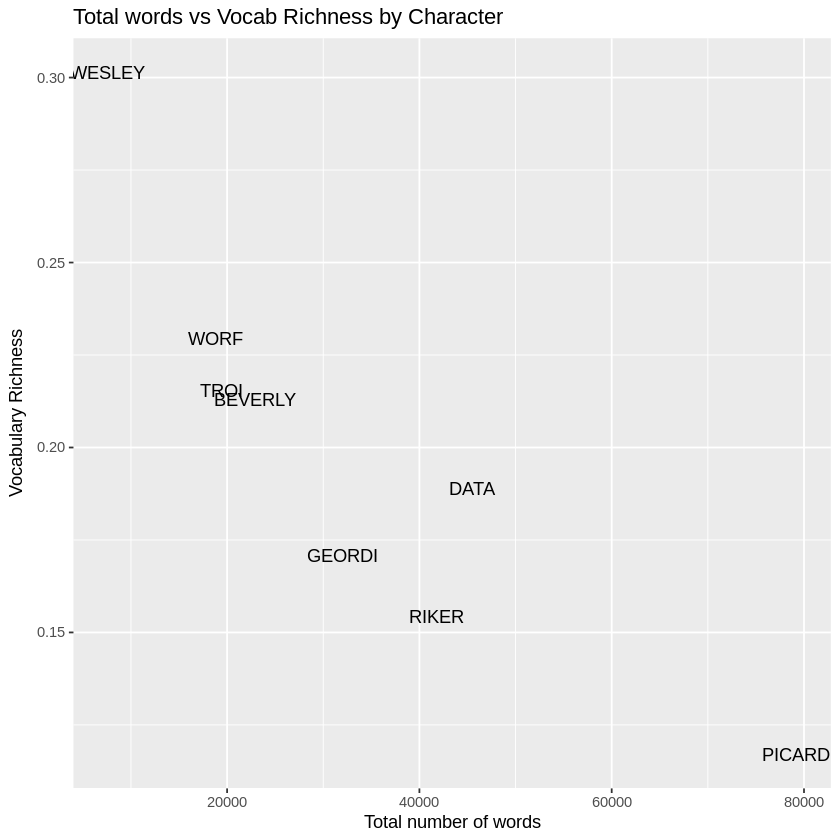

In [50]:
ggplot(unique_words, aes(x = total_words, y=richness, label = character)) +
  geom_text() +
  theme(legend.position = "none") +
  labs(x = "Total number of words", y = "Vocabulary Richness", title = "Total words vs Vocab Richness by Character")

Wesley did not have a high total number of words, but he did have a high vocabulary richness.

Picard speaks a lot but has low richness.

There seems to be 4 groups in which the characters fall into. I have never watched the show so honestly this doesnt really tell me anything substantial.

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row.
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap.

In [51]:
dialogs_wes <- dialogs |>
  filter(character=="WESLEY", (episode_number >= 175))

episode_means_wes <- dialogs_wes|>
  group_by(episode_number) |>
  summarize(mean_dialog_length = mean(str_length(dialog)), .groups = "drop")

episode_means_wes

episode_number,mean_dialog_length
<dbl>,<dbl>
175,36.38889
176,66.50000
177,53.55556
178,18.66667
179,49.97368
181,45.00000
183,52.17021
206,46.90076
219,53.56338


Wesley stops being a main character after episode 183

#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?

Wesley makes cameo appearances in episodes 206, 219, 263, and 272

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

In [52]:
last_dialogue <- dialogs_fixed |>
  filter(character == "WESLEY", episode_number == 183 ) |>
  slice_tail(n = 1)

last_line <- dialogs_fixed |>
  filter(character == "WESLEY", episode_number == 272) |>
  slice_tail(n = 1)

last_dialogue <- last_dialogue |>
  rbind(last_line)

last_dialogue

episode_number,character,dialog,dialog_length
<dbl>,<chr>,<chr>,<int>
183,WESLEY,I can walk.,11
272,WESLEY,"Good-bye, Mom.",14


## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title.
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

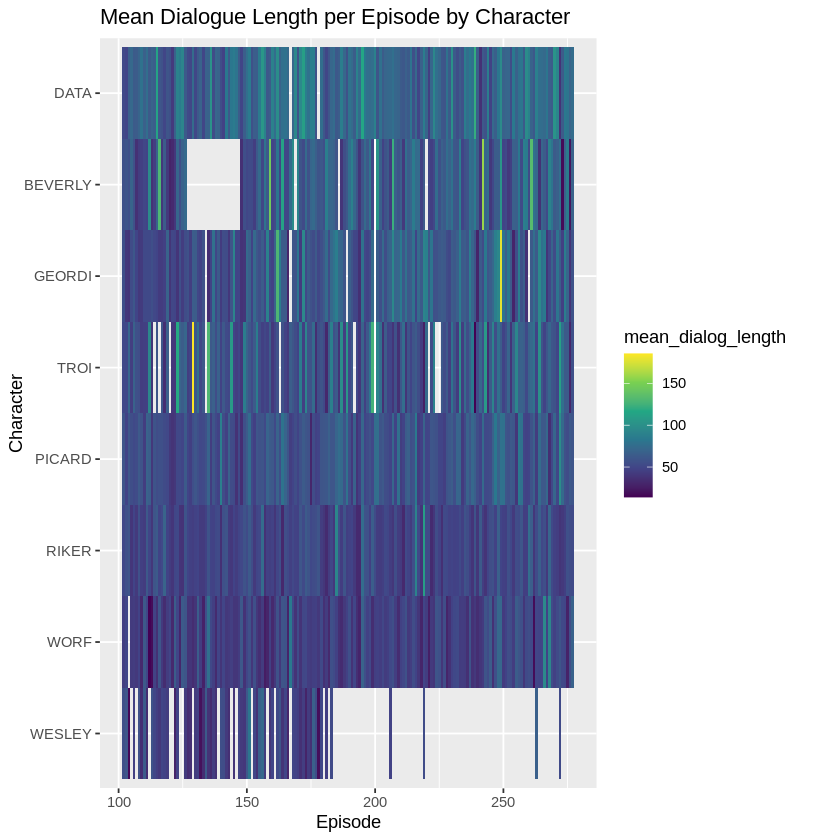

In [53]:
character_dialogues <- dialogs %>%
  group_by(character, episode_number) %>%
  summarize(mean_dialog_length = mean(str_length(dialog)), .groups = "drop") %>%
  group_by(character) %>%
  summarize(mean_dialog_len_per_ep = mean(mean_dialog_length), .groups="drop") %>%
  arrange(mean_dialog_len_per_ep) %>%
  pull(character)

dialog_len_per_ep <- dialog_len_per_ep %>%
  mutate(character = factor(character, levels = character_dialogues))

ggplot(dialog_len_per_ep, aes(x = episode_number, y = character, fill = mean_dialog_length)) +
  geom_tile() +
  scale_fill_viridis_c() +
  labs(
    title = "Mean Dialogue Length per Episode by Character",
    x = "Episode",
    y = "Character"
  )
